# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI()


## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [3]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")


618 frames read.


Display frames to make sure we've read them in correctly:


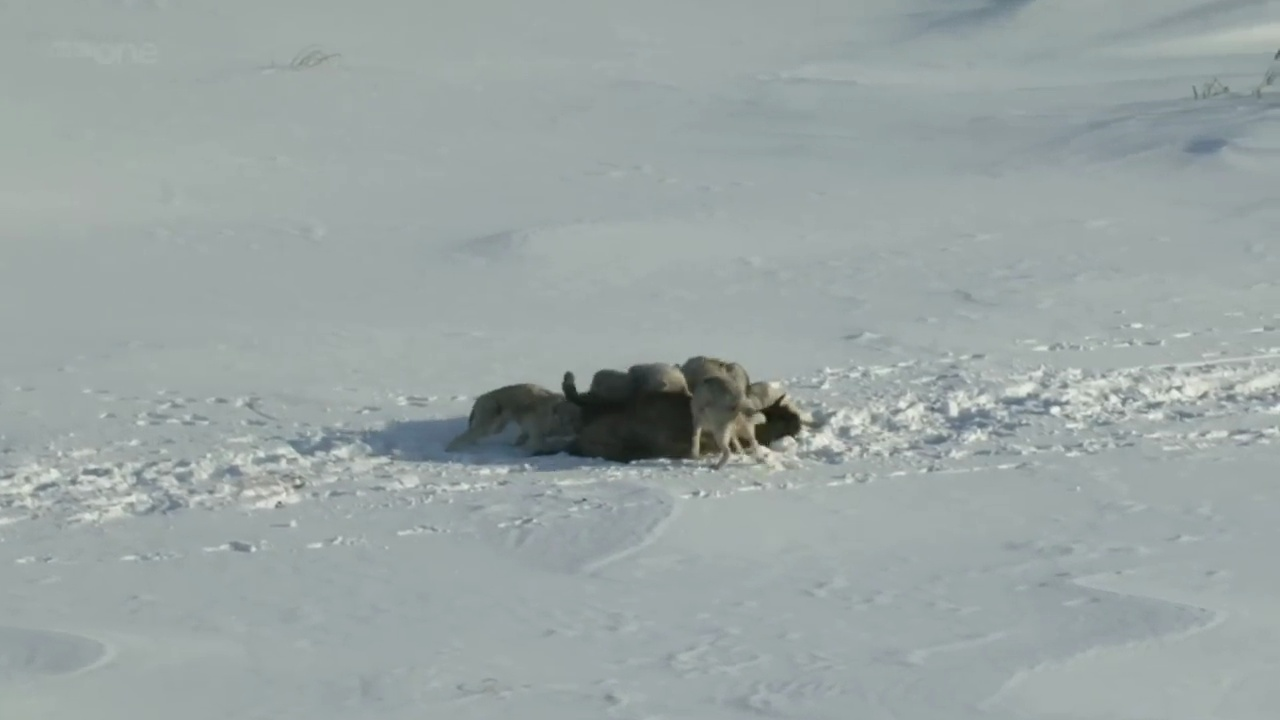

In [4]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)


Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


Title: "Survival in the Snow: A Bison's Stand Against a Wolf Pack"

Description: Witness the raw beauty and intense drama of the wild with this mesmerizing video capturing a tense encounter in a snow-covered landscape. A lone bison finds itself in a perilous standoff against a determined pack of wolves. Experience nature's harsh reality through this gripping footage as the bison bravely defends itself against the stealthy predators. Watch as the surrounding scenery erupts into a breathtaking battle for survival, where each move could be the difference between life and death. This video promises to bring you to the edge of your seat with its unfiltered glimpse into the struggles faced by wildlife in their natural habitat. Don't miss this astonishing display of strength and survival instinct in the unforgiving winter wilderness.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [6]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


In the vast expanse of this winter wonderland, a drama unfolds on the pristine snow. Here, the bison, a giant of the plains, becomes the focus of a pack of wolves, nature's skilled hunters. The wolves circle, a strategic game of life and survival commencing. The bison, with sheer force and unpredictable power, defends itself, kicking up clouds of snow as it tries to thwart its opponents.

Despite the bison's formidable strength, the wolves are persistent, their coordinated efforts are a dance of ancient instincts. The pack knows that persistence can turn the tide in their favor. As the chase continues, the tension builds, the outcome of this conflict hidden by the swirling snow.

Finally, the struggle reaches its climax. The relentless wolves, emboldened by their pack tactics and honed skills, capitalize on a moment of vulnerability. The bison succumbs to the overwhelming odds as the wolves claim their hard-earned prize, a stark reminder of the harsh realities of the natural world wher

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [7]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)
